# Introduction to Data Cleaning

## Introduction

The aim of this session is to introduce some of the basic data cleaning concepts and identify which are the sources of problems from gathering to transformations.

It is often said that 80% of data analysis is spent on the process of cleaning and preparing the data (Dasu T, Johnson T (2003). Exploratory Data Mining and Data Cleaning. Wiley-IEEE.), so it's worth devoting some time to understand the main issues we can find in this cleaning process.

The main problem Data Cleaning tries to solve is to transform Dirty Data into data that is ready for analysis or any other kind of meaningful management (i.e. model building, summarization, visualization)

### What is Dirty Data?
There's probably no definition of dirty data nor Clean Data, so we will try to answer this question by identifying data sources and the problems they have when we try to process the data.

### What you will learn in this session
* Which are the main sources of data
* What we understand for Dirty Data and Clean Data
* How to apporach the data cleaning problem in 5 steps
* What kind of problems we may face during the process
* What kind of data can a data source contain

### Contents

* [Data Sources](#Data-Sources)

## Data Sources

Let's begin with the identification of the main sources where we may gather data. 

We will define a Data Source as "*a digital register or sets of digital registers that contain named values*".

Each source can be a focus of non properly saved data and have its own problems.

* **Federated data:** data coming from one data base or a group of databases through a unified model.
    * Example of SQL normalized database (real example):
        * **Objective:** build a model to predict the weight of a cow during its breeding
        * **Data source:** MySQL 'normalized' database with multiple tables
        * **Approach:** Transform data to build a dataset ready to feed a supervised learning model 
        * **Problems found:**
            * *The carton milk cow:* cows that entered in the farm but at some point were lost and no out record found
            * *The zombie cow:* cows that after been registered as dead, appeared at some part of the farm

##### How to load data from a database?:
1. Dumping data into a file, then scrap (SQL example). We will use the example MySQL DB form: https://github.com/datacharmer/test_db. Clone the repo to `data/`.

In [3]:
with open("../data/test_db/load_employees.dump", "r") as f:
    sql_dump = f.read()
sql_dump[:100]

"INSERT INTO `employees` VALUES (10001,'1953-09-02','Georgi','Facello','M','1986-06-26'),\n(10002,'196"

In [13]:
sql_values = sql_dump.split("VALUES")
sql_values = [line.split(",")[:-1] for line in sql_values[1].split("\n")]
sql_values[:3]

[[' (10001', "'1953-09-02'", "'Georgi'", "'Facello'", "'M'", "'1986-06-26')"],
 ['(10002', "'1964-06-02'", "'Bezalel'", "'Simmel'", "'F'", "'1985-11-21')"],
 ['(10003', "'1959-12-03'", "'Parto'", "'Bamford'", "'M'", "'1986-08-28')"]]

In [23]:
import re

def clean_symbols(in_string):
    out_string =  re.sub(r'[^\w]', '', in_string)
    return out_string

clean_dataset = []
for register in sql_values:
    clean_dataset.append([clean_symbols(line) for line in register])

In [24]:
clean_dataset[:3]

[['10001', '19530902', 'Georgi', 'Facello', 'M', '19860626'],
 ['10002', '19640602', 'Bezalel', 'Simmel', 'F', '19851121'],
 ['10003', '19591203', 'Parto', 'Bamford', 'M', '19860828']]

2. Progamatically quering (you'll need to install `mysql`):

In [32]:
import json
# put your credentials into a json file in resources/mysql_credentials.json
def load_credentials(my_credentials):
    with open(my_credentials, "r") as f:
        cred = json.load(f)
        
    return cred["user"], cred["password"]

user, password = load_credentials("../resources/mysql_credentials.json")

In [33]:
#!/usr/bin/python
import MySQLdb

db = MySQLdb.connect(host="localhost",    # your host, usually localhost
                     user=user,         # your username
                     passwd=password,  # your password
                     db="employees")        # name of the data base

# you must create a Cursor object. It will let
#  you execute all the queries you need
cur = db.cursor()

# Use all the SQL you like
cur.execute("SELECT * FROM employees")

emplyees = [row for row in cur.fetchall()]
db.close()

In [34]:
emplyees[:3]

[(10001,
  datetime.date(1953, 9, 2),
  'Georgi',
  'Facello',
  'M',
  datetime.date(1986, 6, 26)),
 (10002,
  datetime.date(1964, 6, 2),
  'Bezalel',
  'Simmel',
  'F',
  datetime.date(1985, 11, 21)),
 (10003,
  datetime.date(1959, 12, 3),
  'Parto',
  'Bamford',
  'M',
  datetime.date(1986, 8, 28))]

* **High dimensional data:** Let’s say we have $n$ samples (a.k.a. data points, instances) and $p$ features (a.k.a. attributes, independent variables, explanatory variables). 

    There's no precise definition of how many dimensions are "high dimensional" so the imprecise definition is that high dimensional data is simply a data set with a very large p (semtimes around 1000)
    * **Medical records:** genomic data have large $p$ and small $n$
    * **Images:** for example a 320x480 image means that we have 153600 variables
    * **Natural Language:** the bag-of-words apporach maps each word of a language to a variable, if we use a one-hot encoding approach it makes a simple sentence to be high dimensional

##### Data Sparsity and Data Density

We may have scenarios with high dimensional spaces that are dense (i.e. images).

In this case we will use the MNIST dataset. This dataset is a very famous dataset for image classification, and it consists of a set of 28x28 handwritten digit images.

In [69]:
!cd ../data/ && wget http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz

--2019-11-11 12:36:48--  http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
S'està resolent yann.lecun.com (yann.lecun.com)… 216.165.22.6
S'està connectant a yann.lecun.com (yann.lecun.com)|216.165.22.6|:80… connectat.
HTTP: s'ha enviat la petició, s'està esperant una resposta… 200 OK
Mida: 9912422 (9,5M) [application/x-gzip]
S'està desant a: «train-images-idx3-ubyte.gz»

train-images-idx3-u 100%[===================>]   9,45M  3,11MB/s    in 3,0s    

2019-11-11 12:36:51 (3,11 MB/s) - s'ha desat «train-images-idx3-ubyte.gz» [9912422/9912422]



In [70]:
import requests
import gzip

f = gzip.open("../data/train-images-idx3-ubyte.gz",'r')

image_size = 28
num_images = 5

import numpy as np
f.read(16)
buf = f.read(image_size * image_size * num_images)
data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
data = data.reshape(num_images, image_size, image_size, 1)

In [71]:
data[0].shape

(28, 28, 1)

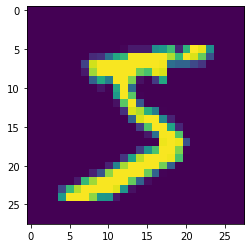

In [72]:
import matplotlib.pyplot as plt
image = np.asarray(data[0]).squeeze()
plt.imshow(image)
plt.show()

In [79]:
num_zeros = 0
for row in image.tolist():
    for pixel in row:
        if pixel == 0:
            num_zeros += 1
print("num of zeros: {} ({}% of the image)".format(num_zeros, 100*num_zeros/(image.shape[0]*image.shape[1])))


num of zeros: 618 (78.8265306122449% of the image)


Status code: 200


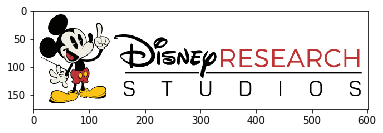

In [93]:
from PIL import Image
import io

url = "https://studios.disneyresearch.com/wp-content/uploads/2019/04/mickeylogo.png"
r = requests.get(url)
print("Status code: {}".format(r.status_code))
image_data = r.content

image = Image.open(io.BytesIO(image_data))
plt.imshow(image)
plt.show()

In [99]:
image.shape

(176, 602, 4)

In [101]:
num_zeros = 0
image = np.array(image)
for channel in image.tolist():
    for row in channel:
        for pixel in row:
            if pixel == 0:
                num_zeros += 1
print("num of zeros: {} ({}% of the image)".format(
    num_zeros, 
    100*num_zeros/(image.shape[0]*image.shape[1]*image.shape[2]))
)

num of zeros: 352326 (83.13340003020235% of the image)


##### Course of dimensionality (from [KDnuggets post](https://www.kdnuggets.com/2017/04/must-know-curse-dimensionality.html))

*"As the number of features or dimensions grows, the amount of data we need to generalize accurately grows exponentially."*

- Charles Isbell, Professor and Senior Associate Dean, School of Interactive Computing, Georgia Tech

So imagine we have 3 observations of an individuum (*i.e.* age of a cow) that is tanged from 0 to 10

In [107]:
x = [3, 2, 7]

This is a fairly small dataset, however our dimension space is 10 as we may want to represent any obsevation.

In [143]:
import sys

# size in bytes
x_space = np.linspace(0,10)
print("%d bytes" % (x_space.nbytes))
print("space dimension: {}".format(max(x_space)))

400 bytes
space dimension: 10.0


Now we want to add a new feature (*i.e.* colour). This variable has a range of 10 colours

In [144]:
y = [0, 1, 2]
y_space = np.linspace(0,10)

# size in bytes
print("%d bytes" % (np.array([x_space, y_space]).nbytes))
print("space dimension: {}".format(max(x_space) * max(y_space)))

800 bytes
space dimension: 100.0


Once again, we add a new variable. Say number of diseases during first year, and we again range this variable to 10 values.

In [145]:
z = [0, 6, 9]
z_space = np.linspace(0,10)

# size in bytes
print("%d bytes" % (np.array([x_space, y_space, z_space]).nbytes))
print("space dimension: {}".format(max(x_space) * max(y_space) * max(z_space)))

1200 bytes
space dimension: 1000.0


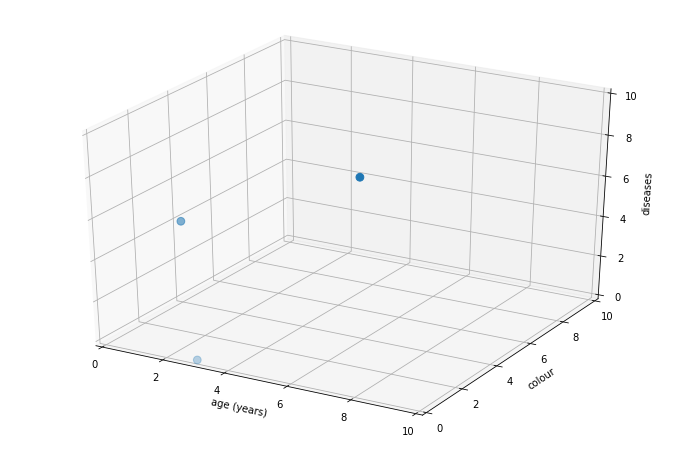

In [136]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x,y,z, s=60)
ax.set_xlim([0, 10])
ax.set_xlabel('age (years)')

ax.set_ylim([0, 10])
ax.set_ylabel('colour')

ax.set_zlim([0, 10])
ax.set_zlabel('diseases')


plt.show()

##### Bigger than memory problem

This problem happens when our dataset is bigger than our RAM memory.

It is a common problem when dealing with high-dimensional data (*i.e.* images, videos).

Take into account that we may have a large Hard Disk, where our data set can be allocated without any problem. However, say we want to transform the dataset or perform some analysis.

The most naïve way of doing such a task is loading the dataset into batches, and perform the action batch per batch.

* **Descriptive data:** a descriptive statistic (in the count noun sense) is a summary statistic that quantitatively describes or summarizes features of a collection of information. 

For example: https://www.ine.es/dyngs/INEbase/es/operacion.htm?c=Estadistica_C&cid=1254736176906&menu=resultados&idp=1254735576820

* **Longitudinal data:** Longitudinal data, sometimes called panel data, is a collection of repeated observations of the same subjects, taken from a larger population, over some time  (track the same sample at different points in time)

* **Streaming data:** Streaming data is data that is continuously generated by different sources
    * A increasing scenario due to IoT raise
    * High frequency: needs of high performance computing
    * High value degradation: validity of data is really short, it has to be consumed at high paces

* **Web (scraped) data:** Potentially unstructred data coded for visualization (i.e. HTML coding)

# Exercises

**Exercise 1:** Load  `data/iqsize.csv` using only the Python Standard Library (you can use the `csv` module if you want. The result should be a **list of lists** containing the values in the csv file.

**Exercise 2:** Instead of using list of lists, do you think that there exist any advantage of using dictionaries (e.g a list of dictionaries)?

**Exercise 3:** Load `data/iqsize.csv` taking advantage of indexes and dictionaries. Describe the problems that you faced so far with this approach.


# Bibliography and referencesc

[1] Jonge van der Loo, Introduction to data cleaning with R - https://cran.r-project.org/doc/contrib/de_Jonge+van_der_Loo-Introduction_to_data_cleaning_with_R.pdf

[2] Dasu T, Johnson T (2003). Exploratory Data Mining and Data Cleaning. Wiley-IEEE.

[3] Hadley Wickman. Tidy Data. http://vita.had.co.nz/papers/tidy-data.pdf 

[4] http://stattrek.com/descriptive-statistics/variables.aspx

[5] Notes of the Introduction to Data Science Course by John Canny